In [14]:
# source: https://python.langchain.com/docs/tutorials/rag/


# Disclaimer

This notebook is an adapted and simplified reproduction of the example in the langchain documentation you can find [here](https://python.langchain.com/docs/tutorials/rag/).

In [15]:
# %pip install --quiet --upgrade langchain-text-splitters langchain-community
# %pip install -qU langchain-openai
# %pip install -qU langchain-core

In [1]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"var: ")

_set_env("OPENAI_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"

_set_env("LANGCHAIN_API_KEY")

# Setting up the Model

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

# Indexing

## Load

In [3]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43130


## Split

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


## Store

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['cfd57e73-b45c-4a52-b543-79eadd9c4e4d', '47924ec7-8393-4134-ba8a-894926e9d756', 'cc238392-b332-4b3e-8110-74962cf59c59']


# Retrieval & Generation

In [6]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [7]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [8]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [10]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [13]:
from langgraph.graph import START, StateGraph, END


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()

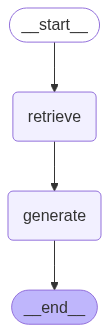

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='91ea85b9-0a31-4630-bdfa-0a5457412ad8', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='cc238392-b332-4b3e-8110-74962cf59c59', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous age

In [16]:
for step in graph.stream(
    {"question": "What are the main elements of an Agent?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='ac7ce4b5-3e8b-4cd8-b595-da845082cac6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 26660}, page_content='Fig. 13. The generative agent architecture. (Image source: Park et al. 2023)\nThis fun simulation results in emergent social behavior, such as information diffusion, relationship memory (e.g. two agents continuing the conversation topic) and coordination of social events (e.g. host a party and invite many others).\nProof-of-Concept Examples#\nAutoGPT has drawn a lot of attention into the possibility of setting up autonomous agents with LLM as the main controller. It has quite a lot of reliability issues given the natural language interface, but nevertheless a cool proof-of-concept demo. A lot of code in AutoGPT is about format parsing.\nHere is the system message used by AutoGPT, where {{...}} are user inputs:\nYou are {{ai-name}}, {{user-provided AI bot description}}.\nYour decisions must always b